In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp")
sys.path.append("/home/vblot/multiaccurate_cp/multiaccurate_cp")

In [2]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

from multiaccurate_cp.domain.model.data_generator import ResidualDataset
from multiaccurate_cp.domain.model.resnet import Resnet


%load_ext autoreload
%autoreload 2


/home/vblot/multiaccurate_cp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATA = "fire"
MODELS_PATH = f"/home/vblot/multiaccurate_cp/data/{DATA}/03_model_weights/resnet"
MODEL_NAME = "20240515_1256"


In [4]:
import yaml

# Specify the path to the YAML file
file_path = os.path.join(MODELS_PATH, MODEL_NAME, "config.yaml")

# Read the YAML file
with open(file_path, "r") as file:
    config = yaml.safe_load(file)


In [5]:
config

{'mean_RGB_values_path': '/home/vblot/multiaccurate_cp/data/fire/02_prepared_data/mean.npy',
 'ml_data_dir': 'data/fire/02_prepared_data',
 'model': {'batch_size': 40,
  'embedding_size': 64,
  'epochs': 100,
  'lr': 0.0001,
  'model_input': 'image_and_probas',
  'num_workers': 8,
  'patience': 20,
  'resnet': 'resnet50',
  'target_recall': 0.9},
 'output_dir': 'data/fire/03_model_weights/resnet',
 'polyp': False,
 'probas_dir': 'data/fire/04_predictions'}

In [6]:
mean_rgb = np.load("/home/vblot/multiaccurate_cp/data/fire/02_prepared_data/mean.npy")
mean_rgb

array([110.36948496,  96.68939452,  89.91067646])

In [7]:
ds = ResidualDataset(
    images_dir=f"/home/vblot/multiaccurate_cp/data/{DATA}/02_prepared_data/test/images",
    labels_dir=f"/home/vblot/multiaccurate_cp/data/{DATA}/02_prepared_data/test/labels",
    pred_probas_dir=f"/home/vblot/multiaccurate_cp/data/{DATA}/04_predictions/test/pred_probas",
    target_recall=config["model"]["target_recall"],
    return_img_path=True,
    model_input=config["model"]["model_input"],
    mean=mean_rgb,
)

6865it [00:00, 111418.99it/s]


In [8]:
models_dir = glob.glob(os.path.join(MODELS_PATH, MODEL_NAME, "checkpoints", "*.ckpt"))
model = Resnet.load_from_checkpoint(
    models_dir[0], resnet=config["model"]["resnet"], model_input=config["model"]["model_input"],
    embedding_size=config["model"]["embedding_size"], target_recall=config["model"]["target_recall"]
)
# model.model.fc = nn.Sequential(*[model.model.fc[i] for i in range(3)])

Using cache found in /home/vblot/.cache/torch/hub/pytorch_vision_v0.9.0


In [9]:
SAVE_PATH = f"/home/vblot/multiaccurate_cp/{DATA}/polyp/04_predictions/test/res_embeddings"

In [10]:
th_preds, ths, recalls = [], [], []
for (model_input, th), img_path in tqdm(ds):
    th_pred = model(torch.tensor(model_input[np.newaxis, ...]).to("cuda")).cpu().detach().numpy()[0, 0]
    # np.save(os.path.join(SAVE_PATH, os.path.basename(img_path).replace(".tif", ".npy")), th_pred)
    # break
    th_preds.append(th_pred)
    ths.append(th)

    mask = cv2.imread(img_path.replace("images", "labels"), cv2.IMREAD_GRAYSCALE)
    pred_proba = model_input[-1, :, :].numpy()
    pred_th = (pred_proba > .18).astype(np.uint8)
    recalls.append(np.sum(pred_th * mask) / np.sum(mask))


  0%|          | 0/6865 [00:00<?, ?it/s]/tmp/ipykernel_2242332/1393108458.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  th_pred = model(torch.tensor(model_input[np.newaxis, ...]).to("cuda")).cpu().detach().numpy()[0, 0]
100%|██████████| 6865/6865 [01:29<00:00, 77.00it/s]


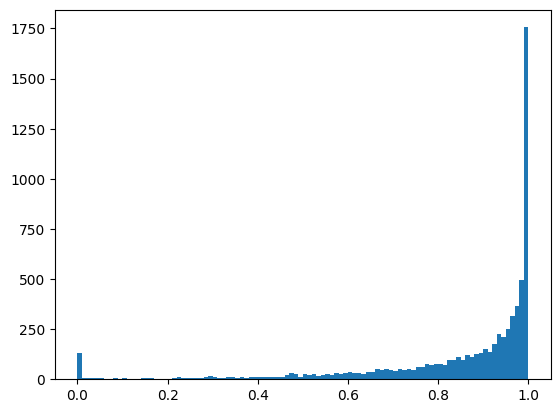

In [11]:
plt.hist(recalls, bins=100)
plt.show()

In [12]:
np.nanmean(recalls)

0.8478681831357766

In [13]:
np.median(recalls)

0.9380548964771744

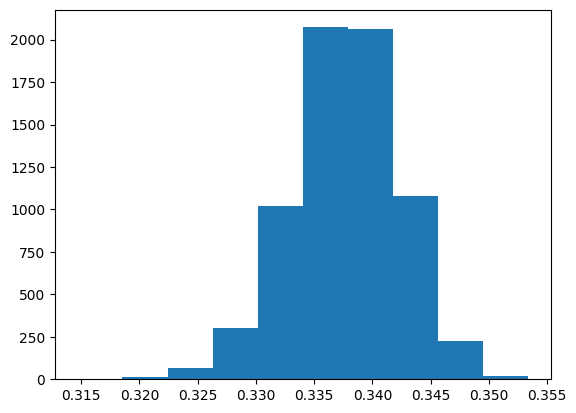

In [14]:
plt.hist(th_preds)
plt.show()

In [15]:
mean_squared_error(ths, th_preds)

0.05283619494263916

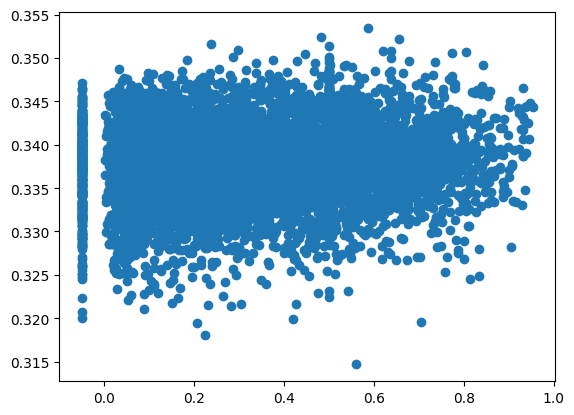

In [16]:
plt.scatter(ths, th_preds)